In [509]:
using Plots, Gurobi, CSV, DataFrames, Statistics, Distances, JuMP



In [510]:
"""
    load_repo_data(repo_path::String)

Recursively walks through the specified repository path, identifies all `.csv` and `.txt` files
(even in subfolders), and parses them into a Dictionary of DataFrames.

# Arguments
- `repo_path::String`: The local path to the cloned repository.

# Returns
- `Dict{String, DataFrame}`: A dictionary where keys are unique filenames and values are DataFrames.
"""
function load_repo_data(repo_path::String)
    # Dictionary to store the parsed data
    data_store = Dict{String, DataFrame}()
    
    # CSV options (assume headers exist)
    csv_options = (header=true, stringtype=String)

    if !isdir(repo_path)
        @error "Directory not found: $repo_path"
        return data_store
    end

    @info "Recursively scanning directory: $repo_path"
    
    files_found = 0
    
    # walkdir allows us to search subdirectories (e.g., /data, /src)
    for (root, dirs, files) in walkdir(repo_path)
        for file in files
            # Check for valid extensions
            if endswith(lowercase(file), ".csv") || endswith(lowercase(file), ".txt")
                
                files_found += 1
                full_path = joinpath(root, file)
                dataset_name = splitext(file)[1]
                
                # Handle duplicate filenames in different folders by appending parent folder name
                if haskey(data_store, dataset_name)
                    parent_folder = basename(root)
                    dataset_name = "$(parent_folder)_$(dataset_name)"
                end

                try
                    @info "Parsing: $full_path"
                    df = CSV.read(full_path, DataFrame; csv_options...)
                    data_store[dataset_name] = df
                catch e
                    # Only warn, don't crash, if a file is malformed
                    @warn "Skipping $file: Unable to parse as CSV table."
                end
            end
        end
    end

    if files_found == 0
        @warn "No CSV or TXT files were found in $repo_path or its subdirectories."
        @info "Current working directory contains: $(readdir(repo_path))"
    else
        @info "Successfully loaded $(length(data_store)) datasets."
    end

    return data_store
end
"""
    summarize_data(data::Dict{String, DataFrame})

Prints a brief summary of the loaded datasets.
"""
function summarize_data(data::Dict{String, DataFrame})
    println("\n--- Data Summary ---")
    for (name, df) in data
        println("Dataset: '$name'")
        println("  Shape: $(nrow(df)) rows × $(ncol(df)) columns")
        println("  Cols:  $(join(names(df), ", "))")
        println("--------------------")
    end
end

repo_path = "." 

# 2. Load the data

subway_data = load_repo_data(repo_path)

# 3. Print summary
summarize_data(subway_data)



[ Info: Recursively scanning directory: .
[ Info: Parsing: .\datasets\MTA_Subway_Hourly_Ridership__Oct_21_2024_Evening.csv
[ Info: Parsing: .\datasets\MTA_Subway_Hourly_Ridership__Oct_21_2024_Morning.csv
[ Info: Parsing: .\datasets\MTA_Subway_Stations_20251204.csv
[ Info: Parsing: .\datasets\agency.txt
[ Info: Parsing: .\datasets\calendar.txt
[ Info: Parsing: .\datasets\calendar_dates.txt
[ Info: Parsing: .\datasets\linecapacity.csv
[ Info: Parsing: .\datasets\linelength.csv
[ Info: Parsing: .\datasets\routes.txt
[ Info: Parsing: .\datasets\shapes.txt
[ Info: Parsing: .\datasets\stop_times.txt



--- Data Summary ---
Dataset: 'routes'
  Shape: 29 rows × 10 columns
  Cols:  route_id, agency_id, route_short_name, route_long_name, route_desc, route_type, route_url, route_color, route_text_color, route_sort_order
--------------------
Dataset: 'nodes_with_ridership'
  Shape: 475 rows × 9 columns
  Cols:  node_idx, stop_id, stop_name, stop_lon, stop_lat, station_complex_id, ridership_morning, ridership_evening, net_ridership
--------------------
Dataset: 'stops'
  Shape: 1488 rows × 6 columns
  Cols:  stop_id, stop_name, stop_lat, stop_lon, location_type, parent_station
--------------------
Dataset: 'trips'
  Shape: 20304 rows × 6 columns
  Cols:  route_id, trip_id, service_id, trip_headsign, direction_id, shape_id
--------------------
Dataset: 'MTA_Subway_Aggregated_Ridership_Oct_21_2024_Evening'
  Shape: 424 rows × 2 columns
  Cols:  station_complex_id, ridership
--------------------
Dataset: 'agency'
  Shape: 1 rows × 6 columns
  Cols:  agency_id, agency_name, agency_url, agency_

[ Info: Parsing: .\datasets\stops.txt
[ Info: Parsing: .\datasets\transfers.txt
[ Info: Parsing: .\datasets\trips.txt
[ Info: Parsing: .\generated_graphs\edges_by_route.csv
[ Info: Parsing: .\generated_graphs\nodes.csv
[ Info: Parsing: .\generated_graphs\nodes_with_balanced_integer_net_ridership.csv
[ Info: Parsing: .\generated_graphs\nodes_with_balanced_net_ridership.csv
[ Info: Parsing: .\generated_graphs\nodes_with_ridership.csv
[ Info: Parsing: .\generated_graphs\routes.csv
[ Info: Parsing: .\generated_graphs\stop_routes.csv
[ Info: Parsing: .\generated_graphs\transfer_edges.csv
[ Info: Parsing: .\generated_turnstile_data\MTA_Subway_Aggregated_Ridership_Oct_21_2024_Evening.csv
[ Info: Parsing: .\generated_turnstile_data\MTA_Subway_Aggregated_Ridership_Oct_21_2024_Morning.csv
[ Info: Parsing: .\generated_turnstile_data\evening_4to8_with_gtfs.csv
[ Info: Parsing: .\generated_turnstile_data\morning_6to10_with_gtfs.csv
[ Info: Successfully loaded 26 datasets.


In [511]:
"""
    build_subway_model(V, E_track, E_transfer, L, L_ij; kwargs...) -> model

Builds the Gurobi/JuMP model for the subway optimization problem with:
- track edges E_track
- transfer edges E_transfer
- line set L
- per-edge line sets L_ij

This ONLY builds the optimizer; it does not read any CSVs.
You must construct the sets and parameter dictionaries before calling it.

Arguments
---------
V::Vector{Station}                # stations (any index type: Int, String, etc.)
E_track::Vector{Tuple{Station,Station}}
E_transfer::Vector{Tuple{Station,Station}}
L::Vector{Line}
L_ij::Dict{Tuple{Station,Station},Vector{Line}}

Keyword parameters (all REQUIRED)
---------------------------------
s::Dict{Station,Float64}                             # s_i
t::Dict{Tuple{Station,Station,Line},Float64}         # t_{ijℓ}
t_tr::Dict{Tuple{Station,Station},Float64}           # t^{tr}_{ij}
C_train::Float64                                     # C_train
Δ::Float64                                           # Δ
τ::Dict{Line,Float64}                                # τ_ℓ
energy::Dict{Line,Float64}                           # energy_ℓ
T_max::Float64                                       # T_max
β::Float64                                           # β
γ::Float64                                           # γ
λ::Float64                                           # λ ∈ [0,1]

Optional
--------
shared_track_constraint::Bool = true

Returns
-------
::JuMP.Model (with Gurobi as optimizer)
"""

function build_subway_model(
    V,
    E_track,
    E_transfer,
    L,
    L_ij;
    s,
    t,
    t_tr,
    C_train,   # Dict{Line,Float64}
    Δ,
    τ,
    energy,
    T_max,
    β,
    γ,
    λ,
    shared_track_constraint::Bool = true,
)

    model = Model(Gurobi.Optimizer)

    # -------------------------
    # 1. Symmetrize the Network
    # -------------------------
    # We build a set of triplets that allows flow in BOTH directions 
    # for every physical connection provided.
    
    triplet_set = Set{Tuple{eltype(V),eltype(V),eltype(L)}}()
    
    # Helper to register a directed edge (i->j) and its reverse (j->i)
    function register_edge(i, j, lines)
        for ℓ in lines
            push!(triplet_set, (i, j, ℓ))
            push!(triplet_set, (j, i, ℓ))
        end
    end

    # Process all input track edges
    for (i, j) in E_track
        lines = get(L_ij, (i, j), Vector{eltype(L)}())
        register_edge(i, j, lines)
    end

    track_triplets = collect(triplet_set)
    
    # Identify unique edges (directional) for iterating constraints
    # (Group by i, j)
    segments = Set{Tuple{eltype(V), eltype(V)}}()
    for (i, j, ℓ) in track_triplets
        push!(segments, (i, j))
    end

    # -------------------------
    # Variables
    # -------------------------
    @variable(model, x[track_triplets] >= 0)
    @variable(model, y[E_transfer] >= 0)
    @variable(model, f[L] >= 0)
    @variable(model, overflow[track_triplets] >= 0)

    # -------------------------
    # (1) Flow Conservation
    # -------------------------
    for i in V
        # Flow leaving i via track
        out_track = sum(
            x[(i, j, ℓ)] 
            for (start_node, j, ℓ) in track_triplets 
            if start_node == i;
            init = 0.0
        )

        # Flow leaving i via transfer
        out_transfer = sum(
            y[(i, j)] 
            for (start_node, j) in E_transfer 
            if start_node == i;
            init = 0.0
        )

        # Flow entering i via track
        in_track = sum(
            x[(k, i, ℓ)] 
            for (k, end_node, ℓ) in track_triplets 
            if end_node == i;
            init = 0.0
        )

        # Flow entering i via transfer
        in_transfer = sum(
            y[(k, i)] 
            for (k, end_node) in E_transfer 
            if end_node == i;
            init = 0.0
        )

        @constraint(model, out_track + out_transfer - in_track - in_transfer == s[i])
    end
    min_frequency = 2.0  # At least 2 trains per hour per line
    for ℓ in L
        @constraint(model, f[ℓ] >= min_frequency)
    end
    # -------------------------
    # (2) Capacity
    # -------------------------
    for (i, j, ℓ) in track_triplets
        # Note: We assume C_train is per-line. 
        # Since we use C_train[ℓ], it applies correctly to both directions.
        @constraint(model, x[(i, j, ℓ)] - overflow[(i, j, ℓ)] <= C_train[ℓ] * f[ℓ] * Δ)
    end

    # -------------------------
    # (3) Shared Track
    # -------------------------
    # We iterate over our discovered segments, not the raw input E_track
    if shared_track_constraint
        for (i, j) in segments
            # Find all lines serving this specific directed segment
            # (We filter the triplets manually or could pre-build a dict)
            lines_on_segment = [l for (u, v, l) in track_triplets if u == i && v == j]
            
            if !isempty(lines_on_segment)
                lhs = sum(x[(i, j, ℓ)] - overflow[(i, j, ℓ)] for ℓ in lines_on_segment)
                rhs = sum(C_train[ℓ] * f[ℓ] * Δ for ℓ in lines_on_segment)
                @constraint(model, lhs <= rhs)
            end
        end
    end

    # -------------------------
    # (4) Fleet/Energy Limit
    # -------------------------
    @constraint(model, sum(f[ℓ] * τ[ℓ] for ℓ in L; init=0.0) <= T_max)

    # -------------------------
    # Objective
    # -------------------------
    
    # Helper to find cost t for (i, j, ℓ) safely
    # If t[(i, j, ℓ)] missing, try t[(j, i, ℓ)]
    function get_cost(i, j, ℓ)
        if haskey(t, (i, j, ℓ))
            return t[(i, j, ℓ)]
        elseif haskey(t, (j, i, ℓ))
            return t[(j, i, ℓ)]
        else
            return 1.0 # Default fallback
        end
    end

    passenger_time_expr =
        sum(get_cost(i, j, ℓ) * x[(i, j, ℓ)] for (i, j, ℓ) in track_triplets; init=0.0) +
        sum(t_tr[(i, j)] * y[(i, j)] for (i, j) in E_transfer; init=0.0)

    overflow_expr = β * sum(overflow[triplet] for triplet in track_triplets; init=0.0)

    energy_expr = γ * sum(energy[ℓ] * f[ℓ] for ℓ in L; init=0.0)

    @objective(model, Min,
        (1 - λ) * (passenger_time_expr + overflow_expr) +
        λ * energy_expr
    )

    return model
end

build_subway_model (generic function with 1 method)

In [512]:
using CSV
using DataFrames

nodes_df      = CSV.read("generated_graphs\\nodes_with_balanced_integer_net_ridership.csv", DataFrame)
routes_df     = CSV.read("generated_graphs\\routes.csv", DataFrame)
edges_df      = CSV.read("generated_graphs\\edges_by_route.csv", DataFrame)
transfers_df  = CSV.read("generated_graphs\\transfer_edges.csv", DataFrame)


Row,transfer_edge_id,from_stop_id,to_stop_id,from_idx,to_idx,transfer_type,min_transfer_time,cost
,Int64,String3,String3,Int64,Int64,Int64,Int64,Int64
1,0,112,A09,9,183,2,180,1
2,1,125,A24,22,196,2,180,1
3,2,127,725,24,174,2,180,1
4,3,127,902,24,177,2,180,1
5,4,127,A27,24,198,2,300,1
6,5,127,R16,24,444,2,180,1
7,6,132,D19,29,263,2,300,1
8,7,132,L02,29,379,2,180,1
9,8,222,415,57,105,2,180,1


In [513]:
const Station = Int
const Line    = Int

Int64

In [514]:
V = sort(unique(Station.(nodes_df.node_idx)))      # stations
L = sort(unique(Line.(routes_df.route_idx)))       # lines
println(size(V))
println(size(L))

(475,)
(26,)


In [515]:
E_track = unique([(Station(row.from_idx), Station(row.to_idx)) 
                  for row in eachrow(edges_df)])
print(size(E_track))

(556,)

In [516]:
L_ij = Dict{Tuple{Station,Station}, Vector{Line}}()

for row in eachrow(edges_df)
    i = Station(row.from_idx)
    j = Station(row.to_idx)
    ℓ = Line(row.route_idx)
    key = (i, j)
    if haskey(L_ij, key)
        push!(L_ij[key], ℓ)
    else
        L_ij[key] = [ℓ]
    end
end

# Remove duplicates within each vector, in case the same route appears multiple times
for lines in values(L_ij)
    unique!(lines)
end
L_ij


Dict{Tuple{Int64, Int64}, Vector{Int64}} with 556 entries:
  (126, 127) => [5]
  (359, 360) => [9, 23]
  (55, 56)   => [1, 4]
  (117, 118) => [5, 6]
  (213, 214) => [9, 11]
  (7, 8)     => [0]
  (223, 224) => [9]
  (14, 15)   => [0]
  (397, 398) => [18]
  (433, 434) => [20, 24]
  (178, 179) => [9]
  (267, 268) => [10, 21]
  (368, 370) => [17]
  (121, 122) => [5, 6]
  (436, 437) => [20, 24]
  (473, 474) => [23]
  (151, 152) => [3, 5, 6]
  (26, 27)   => [0, 1]
  (154, 155) => [7, 8]
  (308, 309) => [14, 15]
  (336, 337) => [16]
  (171, 172) => [7, 8]
  (345, 346) => [16]
  (261, 262) => [14, 15, 19]
  (444, 445) => [20, 24, 21, 22]
  ⋮          => ⋮

In [517]:
E_transfer = unique([(Station(row.from_idx), Station(row.to_idx))
                     for row in eachrow(transfers_df)])
println(size(E_transfer))

(150,)


In [518]:
t_tr = Dict((i, j) => 1.0 for (i, j) in E_transfer)

Dict{Tuple{Int64, Int64}, Float64} with 150 entries:
  (416, 429) => 1.0
  (63, 418)  => 1.0
  (472, 212) => 1.0
  (429, 152) => 1.0
  (172, 144) => 1.0
  (24, 177)  => 1.0
  (212, 472) => 1.0
  (416, 451) => 1.0
  (198, 174) => 1.0
  (453, 205) => 1.0
  (453, 62)  => 1.0
  (429, 451) => 1.0
  (29, 263)  => 1.0
  (335, 294) => 1.0
  (456, 66)  => 1.0
  (177, 444) => 1.0
  (422, 238) => 1.0
  (169, 335) => 1.0
  (198, 177) => 1.0
  (173, 260) => 1.0
  (176, 172) => 1.0
  (73, 474)  => 1.0
  (107, 63)  => 1.0
  (379, 263) => 1.0
  (148, 448) => 1.0
  ⋮          => ⋮

In [519]:
t = Dict{Tuple{Station,Station,Line}, Float64}()

for row in eachrow(edges_df)
    i = Station(row.from_idx)
    j = Station(row.to_idx)
    ℓ = Line(row.route_idx)
    key = (i, j, ℓ)
    
    # If every segment has the same unit cost:
    t[key] = 1.0

    # Later you can replace that with actual in-train travel time per edge
    # t[key] = real_travel_time_in_hours
end


In [520]:
s = Dict{Station, Float64}()

for row in eachrow(nodes_df)
    i = Station(row.node_idx)
    s[i] = Float64(row.balanced_net_ridership_int)
end

# Optionally, ensure every station in V has an entry, even if 0:
for i in V
    if !haskey(s, i)
        s[i] = 0.0
    end
end


In [521]:
# 1. Create a mapping from Name -> ID using the ROUTES dataframe (the source of truth for the model)
name_to_id = Dict(row.route_short_name => Line(row.route_idx) for row in eachrow(routes_df))

linecap_df = CSV.read("datasets\\linecapacity.csv", DataFrame)

C_train = Dict{Line, Float64}()

# 2. Iterate through linecapacity and assign to the CORRECT model index
for row in eachrow(linecap_df)
    r_name = row.route_short_name
    
    if haskey(name_to_id, r_name)
        ℓ = name_to_id[r_name]
        C_train[ℓ] = Float64(row.total_rush_hour_capacity)
    else
        @warn "Capacity data found for route '$r_name' but it is not in the graph."
    end
end

# 3. Safety Check: Ensure all lines in L have a capacity
for ℓ in L
    if !haskey(C_train, ℓ)
        @warn "No capacity defined for route index $ℓ. Defaulting to 1000."
        C_train[ℓ] = 1000.0 
    end
end

In [522]:
const AVG_SPEED_MPM = 0.29 


df_len = subway_data["linelength"]

τ = Dict{Int, Float64}()
energy = Dict{Int, Float64}()

for row in eachrow(df_len)
    ridx = row.route_idx
    if ridx in L
        miles = row."route_length(mi)"
        
        # Estimate Round Trip Time (τ):
        # (Length / Speed) * 2 for return + 10% layover buffer
        time_one_way = miles / AVG_SPEED_MPM
        τ[ridx] = time_one_way * 2.0 * 1.1
        
        # Energy proxy: proportional to route length
        energy[ridx] = miles 
    end
end

# Fill defaults for any missing routes (e.g., shuttles not in linelength)
avg_tau = isempty(τ) ? 60.0 : mean(values(τ))
avg_energy = isempty(energy) ? 10.0 : mean(values(energy))

for ℓ in L
    if !haskey(τ, ℓ)
        τ[ℓ] = avg_tau
        energy[ℓ] = avg_energy
    end
end

Δ = 1      # 1 hour horizon
T_max = 43500.0  # train hours limit
β = 50000.0     # Penalty for overflow (unmet demand)
γ = 16.0       # Penalty for energy/operation cost
λ = 0.5       # Balance parameter


model = build_subway_model(
    V,
    E_track,
    E_transfer,
    L,
    L_ij;
    s      = s,
    t      = t,
    t_tr   = t_tr,
    C_train = C_train,
    Δ       = Δ,
    τ       = τ,
    energy  = energy,
    T_max   = T_max,
    β       = β,
    γ       = γ,
    λ       = λ,
)

optimize!(model)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2703606
Academic license 2703606 - for non-commercial use only - registered to ju___@mit.edu
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Academic license 2703606 - for non-commercial use only - registered to ju___@mit.edu
Optimize a model with 3692 rows, 4332 columns and 16976 nonzeros
Model fingerprint: 0x835ef402
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [5e-01, 3e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+04]
Presolve removed 574 rows and 111 columns
Presolve time: 0.01s
Presolved: 3118 rows, 4221 columns, 15268 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8400000e+32   1.600000e+31   3.840000e+02      0s
    1

In [523]:
"""
    get_optimized_frequencies(model, L, routes_df)

Extracts the optimized frequency values (f) for each line from the solved JuMP model.
Returns a DataFrame sorted by route name.
"""
function get_optimized_frequencies(model, L, routes_df)
    # 1. Check if model has a solution
    if termination_status(model) != MOI.OPTIMAL
        @warn "Model not optimal! Status: $(termination_status(model))"
        # Proceeding anyway to show partial results if available...
    end

    # 2. Create a map from Route Index -> Route Name
    # (Assuming routes_df has :route_idx and :route_short_name)
    idx_to_name = Dict(r.route_idx => r.route_short_name for r in eachrow(routes_df))

    results = []

    # 3. Iterate over all lines in set L
    for ℓ in L
        # Retrieve the value of the variable f for line ℓ
        # Use JuMP.value(...) to get the numeric result
        f_val = value(model[:f][ℓ])
        
        # Get the friendly name
        r_name = get(idx_to_name, ℓ, "Line $ℓ")
        
        # Determine approx headway (minutes) if frequency > 0
        headway_min = f_val > 1e-6 ? (60.0 / f_val) : Inf

        push!(results, (
            route_idx = ℓ, 
            route_name = r_name, 
            trains_per_hour = round(f_val, digits=2),
            headway_mins = round(headway_min, digits=1)
        ))
    end

    # 4. Convert to DataFrame and sort
    df_results = DataFrame(results)
    sort!(df_results, :route_name)
    
    return df_results
end

resulting_frequencies = get_optimized_frequencies(model, L, routes_df)
println(resulting_frequencies)

26×4 DataFrame
 Row │ route_idx  route_name  trains_per_hour  headway_mins 
     │ Int64      String3     Float64          Float64      
─────┼──────────────────────────────────────────────────────
   1 │         0  1                     10.72           5.6
   2 │         1  2                      2.0           30.0
   3 │         2  3                      2.0           30.0
   4 │         3  4                     14.87           4.0
   5 │         4  5                     23.67           2.5
   6 │         5  6                      2.53          23.7
   7 │         6  6X                    19.07           3.1
   8 │         7  7                      7.26           8.3
   9 │         8  7X                    13.49           4.4
  10 │         9  A                     24.57           2.4
  11 │        10  B                      9.59           6.3
  12 │        11  C                      2.0           30.0
  13 │        12  D                     10.53           5.7
  14 │        13  E   

In [524]:
"""
    get_total_ridership(s)

Calculates the total number of riders (passengers) modeled in the system
by summing all positive net-ridership entries.
"""
function get_total_ridership(s)
    # Sum of all positive net ridership values (Entries)
    total_riders = sum(val for val in values(s) if val > 0)
    
    println("--------------------------------")
    println("Total Ridership (System-Wide): $(round(Int, total_riders))")
    println("--------------------------------")
    
    return total_riders
end

# --- Usage ---
# Run this after you have defined 's' (it does not strictly require the solved model, 
# as 's' is the input, but this confirms what the model attempted to route).
get_total_ridership(s)

--------------------------------
Total Ridership (System-Wide): 1525774
--------------------------------


1.525774e6

In [525]:
println("\n=== DIAGNOSTIC INFORMATION ===")
println("Objective Value: ", objective_value(model))
println("Termination Status: ", termination_status(model))

# Check fleet utilization
total_fleet_used = sum(value(model[:f][ℓ]) * τ[ℓ] for ℓ in L)
println("\nFleet Constraint:")
println("  Used: $(round(total_fleet_used, digits=1)) / $(T_max)")
println("  Utilization: $(round(100*total_fleet_used/T_max, digits=1))%")



=== DIAGNOSTIC INFORMATION ===
Objective Value: 6.838332496402673e6
Termination Status: OPTIMAL

Fleet Constraint:
  Used: 43500.0 / 43500.0
  Utilization: 100.0%


--- Frequency Comparison (Corrected: Per Direction) ---


Row,route_idx,route_name,trains_per_hour,headway_mins,actual_tph,diff
,Int64,String3,Float64,Float64,Int64,Float64
1,14,F,34.97,1.7,33,1.97
2,6,6X,19.07,3.1,19,0.07
3,15,FX,2.0,30.0,2,0.0
4,23,S,4.6,13.1,5,-0.4
5,17,J,15.6,3.8,17,-1.4
6,23,S,4.6,13.1,6,-1.4
7,25,Z,3.3,18.2,6,-2.7
8,18,L,22.86,2.6,27,-4.14
9,4,5,23.67,2.5,29,-5.33


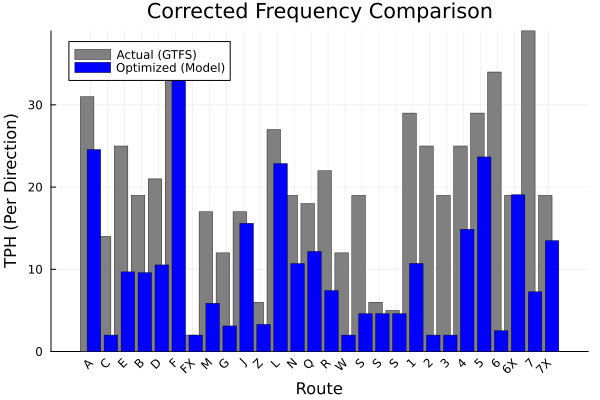

In [526]:
using DataFrames, Statistics, Dates, Plots

function calculate_actual_tph(data_store, start_hour::Int, end_hour::Int)
    trips_df      = data_store["trips"]
    stop_times_df = data_store["stop_times"]
    routes_df     = data_store["routes"]
    calendar_df   = data_store["calendar"]

    # 1. Filter for Weekday Service
    active_services = filter(r -> r.monday == 1 && r.tuesday == 1 && r.wednesday == 1, calendar_df).service_id
    weekday_trips = filter(r -> r.service_id in active_services, trips_df)
    
    # 2. Filter for Time Window
    t_start = lpad(string(start_hour), 2, '0') * ":00:00"
    t_end   = lpad(string(end_hour), 2, '0') * ":00:00"
    
    peak_stops = filter(r -> r.arrival_time >= t_start && r.arrival_time < t_end, stop_times_df)
    active_trip_ids = unique(peak_stops.trip_id)
    
    # 3. Filter Trips
    peak_trips = filter(r -> r.trip_id in active_trip_ids, weekday_trips)
    
    # 4. Count trips per Route AND Direction
    # This prevents summing Northbound + Southbound
    dir_counts = combine(groupby(peak_trips, [:route_id, :direction_id]), nrow => :dir_tph)
    
    # 5. Get the Peak Frequency for the Line
    # taking `maximum` ensures that for the F train (30 NB, 30 SB) we get 30,
    # and for 6X (19 Peak, 0 Reverse) we get 19.
    actual_counts = combine(groupby(dir_counts, :route_id), :dir_tph => maximum => :actual_tph)
    
    # 6. Merge with Route Names
    actual_freq = leftjoin(actual_counts, routes_df, on=:route_id)
    
    return select(actual_freq, :route_short_name => :route_name, :actual_tph)
end

# --- Run Comparison Again ---
actual_df = calculate_actual_tph(subway_data, 17, 18)
comparison_df = leftjoin(resulting_frequencies, actual_df, on=:route_name)
comparison_df.actual_tph = coalesce.(comparison_df.actual_tph, 0)
comparison_df.diff = comparison_df.trains_per_hour .- comparison_df.actual_tph

println("--- Frequency Comparison (Corrected: Per Direction) ---")
display(sort(comparison_df, :diff, rev=true))

# --- Plotting (Same as before) ---
routes_labels = comparison_df.route_name
n_routes = length(routes_labels)
x_indices = 1:n_routes
width = 0.4

p = bar(x_indices .- width/2, comparison_df.actual_tph, width=width, label="Actual (GTFS)", color=:gray, legend=:topleft)
bar!(x_indices .+ width/2, comparison_df.trains_per_hour, width=width, label="Optimized (Model)", color=:blue)
plot!(p, xticks=(x_indices, routes_labels), xrotation=45, xlabel="Route", ylabel="TPH (Per Direction)", title="Corrected Frequency Comparison")
display(p)

Starting Pareto Frontier generation...
Solving for λ = 0.0 ...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2703606
Academic license 2703606 - for non-commercial use only - registered to ju___@mit.edu
Solving for λ = 0.1 ...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2703606
Academic license 2703606 - for non-commercial use only - registered to ju___@mit.edu
Solving for λ = 0.2 ...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2703606
Academic license 2703606 - for non-commercial use only - registered to ju___@mit.edu
Solving for λ = 0.3 ...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2703606
Academic license 2703606 - for non-commercial use only - registered to ju___@mit.edu
Solving for λ = 0.4 ...
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2703606
Academic license 2703606 - for non-commercial 

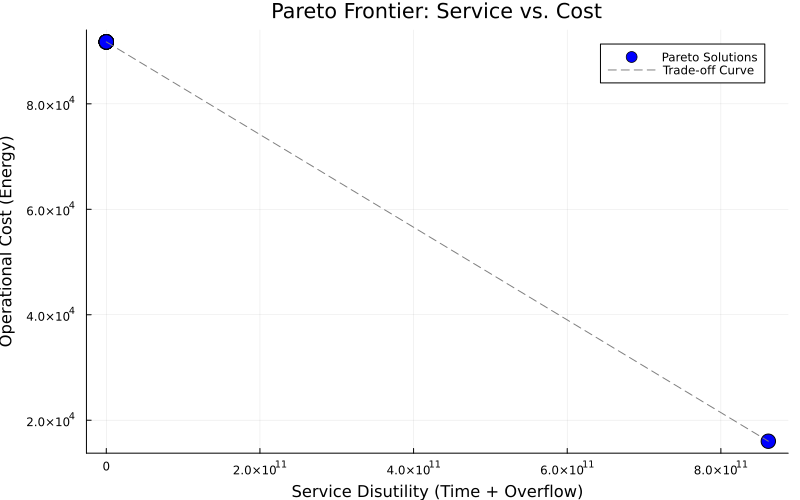

In [ ]:
using Plots, JuMP, Gurobi

# --- 1. Reconstruct track_triplets for iteration ---
# We need the exact set of (i, j, l) tuples used in the model to sum up costs correctly.
triplet_set = Set{Tuple{Int,Int,Int}}()
for (i, j) in E_track
    lines = get(L_ij, (i, j), [])
    for ℓ in lines
        push!(triplet_set, (i, j, ℓ))
        push!(triplet_set, (j, i, ℓ)) # Symmetrized
    end
end
track_triplets_global = collect(triplet_set)

# --- 2. Pareto Loop ---
lambdas = 0.0:0.1:1.0
service_vals = Float64[]
cost_vals    = Float64[]

println("Starting Pareto Frontier generation...")

for val_lambda in lambdas
    println("Solving for λ = $val_lambda ...")
    
    # Build and solve
    model_pareto = build_subway_model(
        V, E_track, E_transfer, L, L_ij;
        s = s, t = t, t_tr = t_tr, C_train = C_train,
        Δ = Δ, τ = τ, energy = energy,
        T_max = T_max, β = β, γ = γ,
        λ = val_lambda
    )
    set_optimizer_attribute(model_pareto, "OutputFlag", 0)
    optimize!(model_pareto)
    
    if termination_status(model_pareto) == MOI.OPTIMAL
        # --- Calculate Metrics Manually ---
        
        # 1. Passenger Time + Transfer Time
        pass_time = 0.0
        
        # Helper for cost lookup
        function get_cost_p(i, j, ℓ)
            if haskey(t, (i, j, ℓ)); return t[(i, j, ℓ)]
            elseif haskey(t, (j, i, ℓ)); return t[(j, i, ℓ)]
            else; return 1.0; end
        end

        # Iterate over the RECONSTRUCTED set, not keys(x)
        for (i, j, ℓ) in track_triplets_global
            # Access variable value safely by index
            flow = value(model_pareto[:x][(i, j, ℓ)])
            pass_time += get_cost_p(i, j, ℓ) * flow
        end
        
        # Transfers
        for (i, j) in E_transfer
            flow = value(model_pareto[:y][(i, j)])
            pass_time += t_tr[(i, j)] * flow
        end
        
        # 2. Overflow Penalty
        val_overflow = value.(model_pareto[:overflow])
        ovf_penalty = β * sum(val_overflow)
        
        # Total Service Disutility
        z1_service = pass_time + ovf_penalty
        
        # 3. Operational Cost (Energy)
        val_f = value.(model_pareto[:f])
        z2_cost = γ * sum(energy[ℓ] * val_f[ℓ] for ℓ in L)
        
        push!(service_vals, z1_service)
        push!(cost_vals, z2_cost)
    else
        println("  Warning: Non-optimal solution for λ=$val_lambda")
    end
end

# --- 3. Plot ---
p_pareto = plot(
    service_vals, 
    cost_vals,
    seriestype = :scatter,
    label = "Pareto Solutions",
    xlabel = "Service Disutility (Time + Overflow)",
    ylabel = "Operational Cost (Energy only)",
    title = "Pareto Frontier: Service vs. Cost",
    legend = :topright,
    marker = (:circle, 8, :blue),
    size = (800, 500)
)
plot!(p_pareto, service_vals, cost_vals, label="Trade-off Curve", line=(:dash, :gray))

display(p_pareto)